# Natural Language Processing - lab 2 (Lemmatization and full text search)

Bartosz Klimza

I'm using also Elasticvue (an extension for Google Chrome)

# Necessary imports

In [1]:
import os
import requests
import json


# First I have installed ElasticSearch and a plugin for Polish

# 3. Define an ES analyzer for Polish texts containing:
    i. standard tokenizer
    ii. synonym filter with the following definitions:
        a. kpk - kodeks postępowania karnego
        b. kpc - kodeks postępowania cywilnego
        c. kk - kodeks karny
        d. kc - kodeks cywilny
    iii. Morfologik-based lemmatizer
    iv. lowercase filter

In [76]:
definition = json.dumps(
    {
   "settings":{
       "analysis":{
           "filter": {
               "new_synonyms": {
                   "type": "synonym",
                   "synonyms": [ # Defining new synonyms
                       "kpk => kodeks postępowania karnego",
                       "kpc => kodeks postępowania cywilnego",
                       "kk => kodeks karny",
                       "kc => kodeks cywilny"]
               }
           },
           "analyzer":{
               "new_analyzer":{ 
                   "type":"custom",
                   "tokenizer":"standard", # Defining a standard tokenizer
                   "filter":[
                       "lowercase", # Defining a lowercase filter
                       "new_synonyms",
                       "morfologik_stem", # Defining a morfologik lemmatizer
                       "stop"]
               }
           }
       }
   },
   "mappings":{
       "properties":{
          "bills": {
             "type":"text",
             "analyzer":"new_analyzer" 
         }
      }
   }
}
)

# 4. Define an ES index for storing the contents of the legislative acts.

In [84]:
new_index = "lab_2_index"

req = requests.put(f"http://localhost:9200/{new_index}", headers={"Content-Type": "application/json"}, data=definition)


# 5. Load the data to the ES index.

In [78]:
data_dir = "./ustawy/"

for file in os.listdir(data_dir):
    bills = open(f"./{data_dir}{file}", "r").read()
    bills = bills.split()
    bills = " ".join(bills)
    bills_data = json.dumps({"title": file, "bills": bills})
    req = requests.post(f"http://localhost:9200/{new_index}/_doc", headers={"Content-Type": "application/json"}, data=bills_data)
    

We can see new index with 1179 documents.

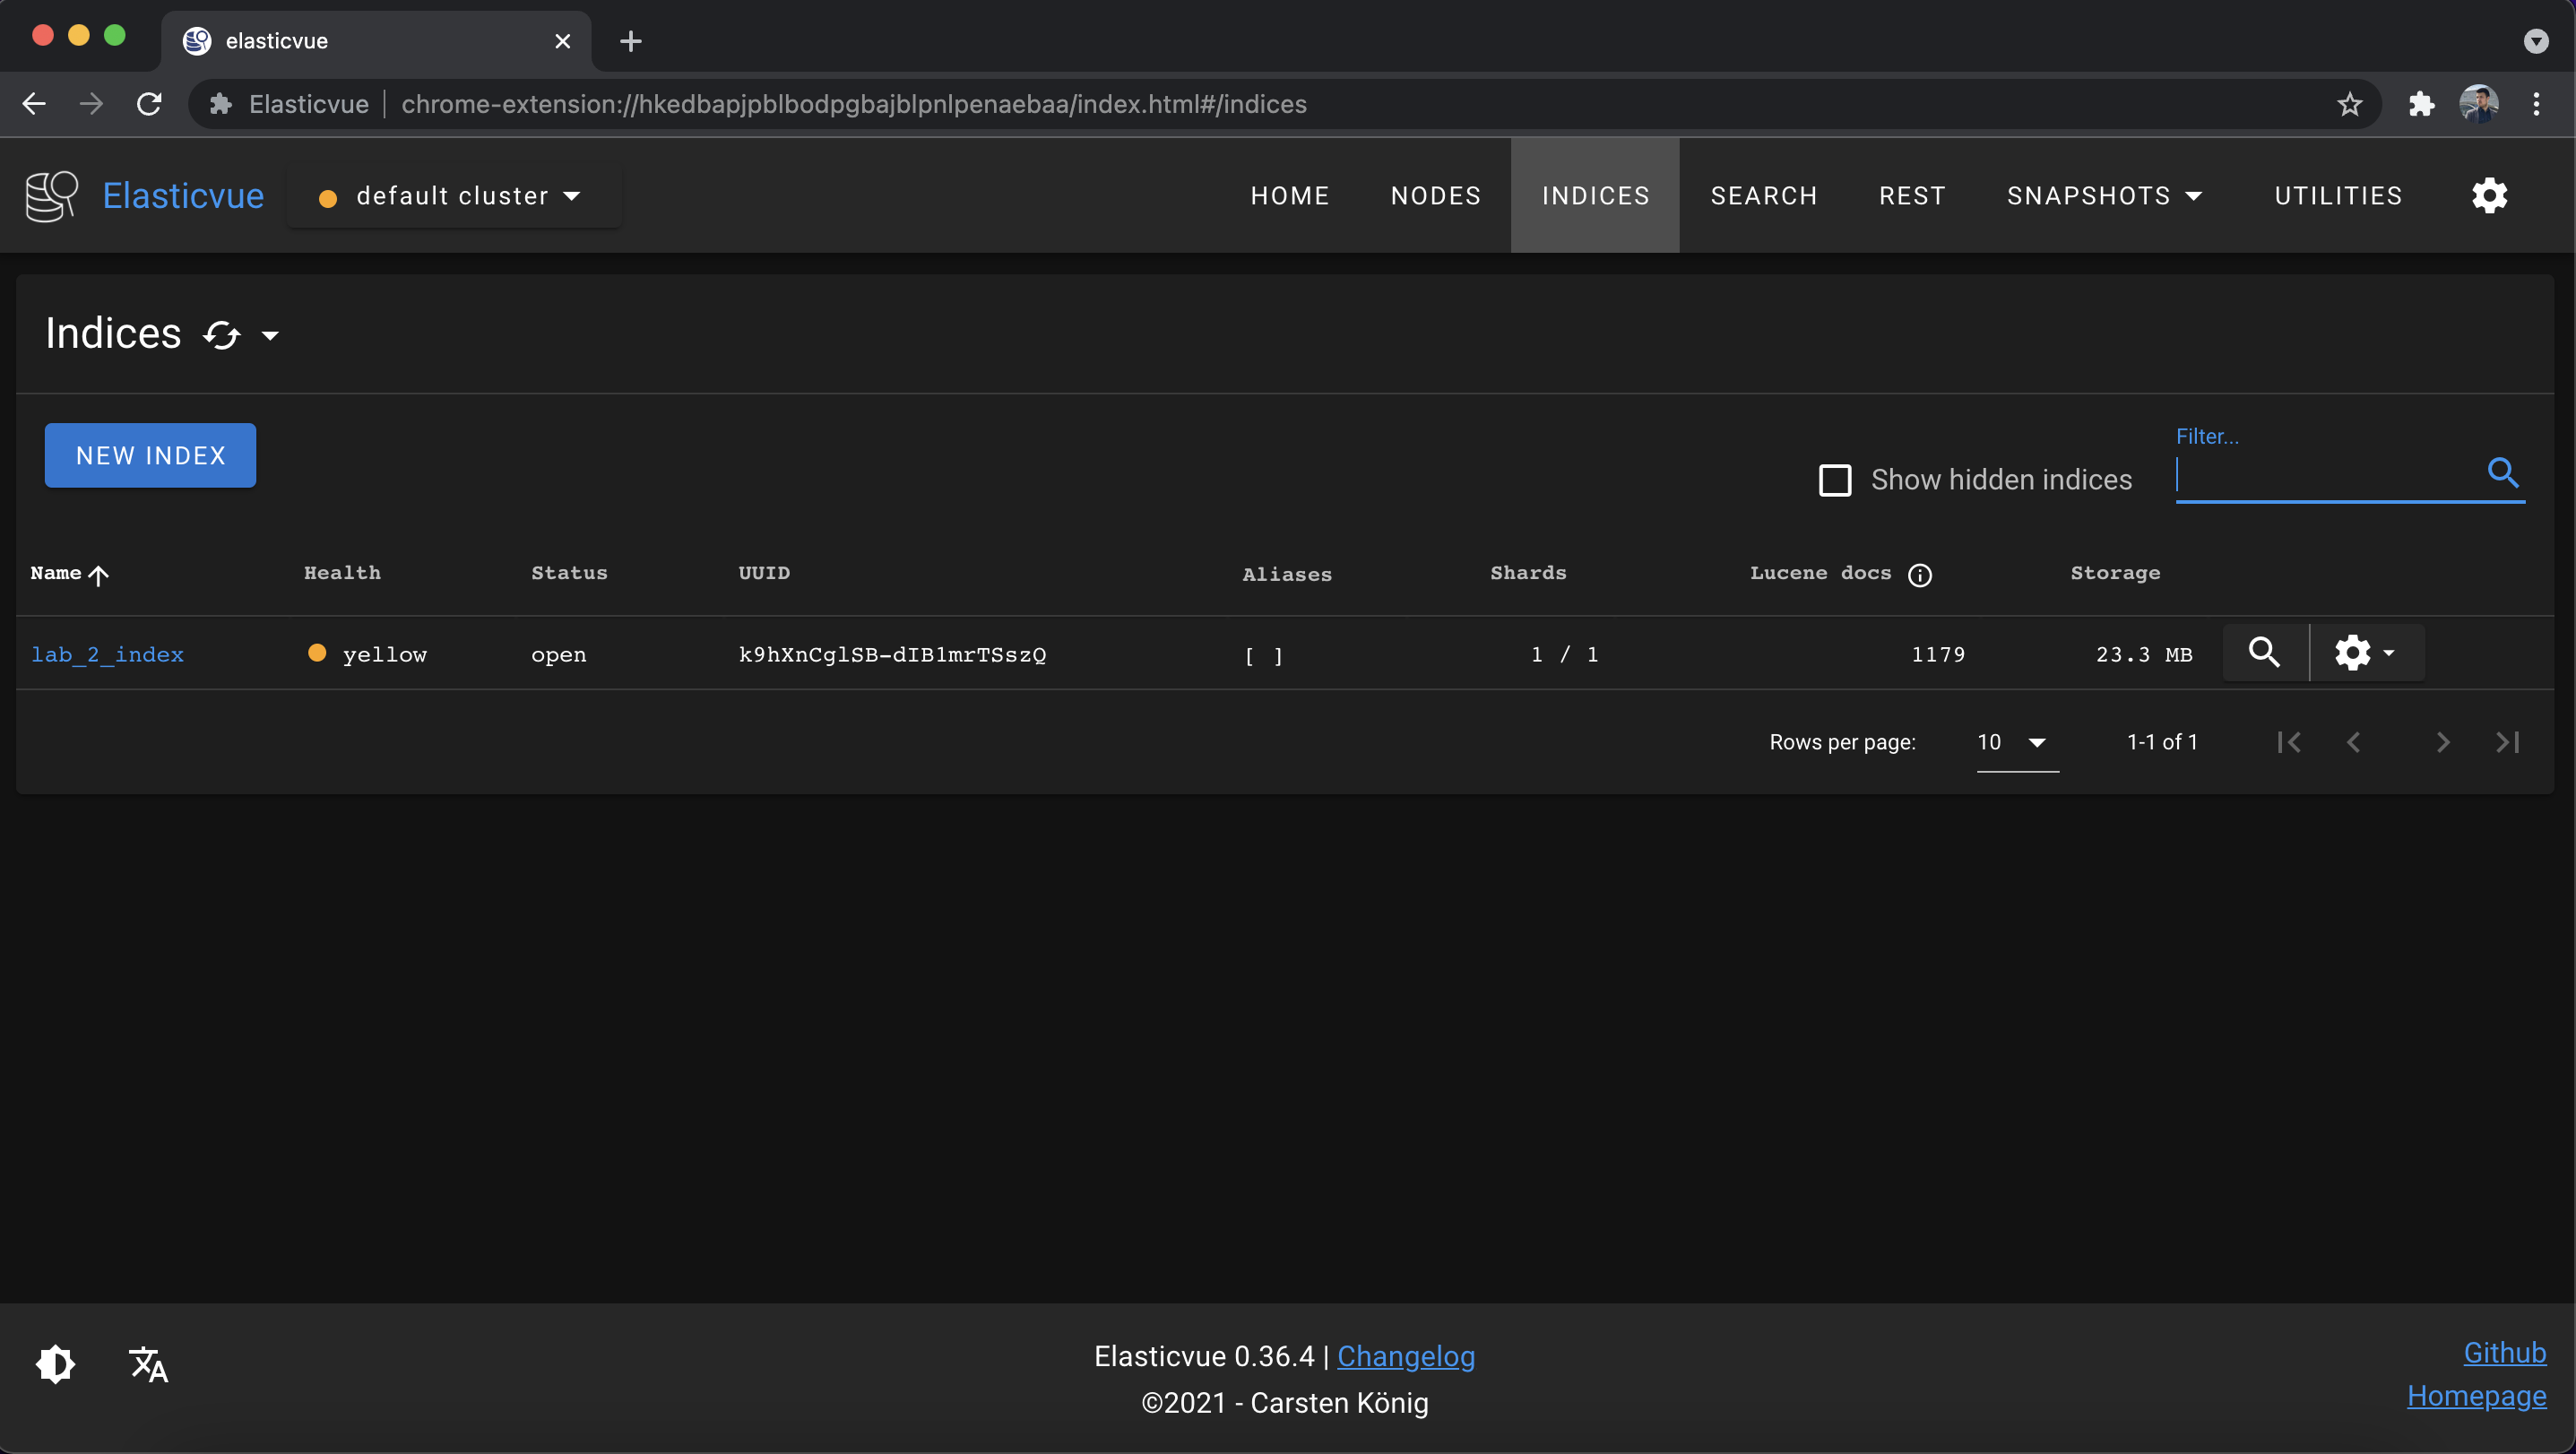

# 6. Determine the number of legislative acts containing the word ustawa (in any form).

In [85]:
ustawa = json.dumps(
    {
        "query": {
            "match": {
                "bills": {
                    "query": "ustawa",
                }
            }
        }
    }
)
req = requests.get(f"http://localhost:9200/{new_index}/_search", headers={"Content-Type": "application/json"}, data=ustawa)
print(req.json()["hits"]["total"]["value"])



1178


# 7. Determine the number of occurrences of the word ustawa by searching for this particular form, including the other inflectional forms.

In [86]:
ustawa_word = json.dumps(
{
  "query": {
    "query_string": {
      "fields": ["bills"],
      "query": "ustawa"
    }
  },  
  "aggs": {
    "my-terms": {
      "terms": {
        "field": "bills.keyword"
      }
    }
  }
}
)

req = requests.get(f"http://localhost:9200/{new_index}/_search", headers={"Content-Type": "application/json"}, data=ustawa_word)
print(req.json())

{'took': 17, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 1178, 'relation': 'eq'}, 'max_score': 0.0026272358, 'hits': [{'_index': 'lab_2_index', '_type': '_doc', '_id': 'ZPmU73wBFnBbRM6iNiQI', '_score': 0.0026272358, '_source': {'title': '1999_1255.txt', 'bills': 'Dz.U. z 1999 r. Nr 110, poz. 1255 USTAWA z dnia 23 grudnia 1999 r. o kształtowaniu wynagrodzeń w państwowej sferze budżetowej oraz o zmianie niektórych ustaw Art. 1. Ustawa określa zasady i tryb kształtowania wynagrodzeń w państwowej sferze budżetowej oraz limity zatrudnienia dla osób objętych mnożnikowymi systemami wynagrodzeń. Art. 2. Przez użyte w ustawie określenia: 1) państwowa sfera budżetowa - rozumie się państwowe jednostki budżetowe, państwowe zakłady budżetowe, gospodarstwa pomocnicze państwowych jednostek budżetowych, które prowadzą gospodarkę finansową na zasadach określonych w art. 18 - 20 ustawy z dnia 26 listopada 1998 r. o finansach public

# 8. Determine the number of occurrences of the word ustaw by searching for this particular form, including the other inflectional forms.

# 9. Determine the number of legislative acts containing the words kodeks postępowania cywilnego in the specified order, but in any inflection form.

In [87]:
kpc = json.dumps(
    {
        "query": {
            "match_phrase": {
                "bills": {
                    "query": "kodeks postępowania cywilnego"
                }
            }
        }
    }
)
req = requests.get(f"http://localhost:9200/{new_index}/_search", headers={"Content-Type": "application/json"}, data=kpc)
print(req.json()['hits']['total']['value'])

44


# 10. Determine the number of legislative acts containing the words wchodzi w życie (in any form) allowing for up to 2 additional words in the searched phrase.

In [88]:
wchodzi_w_zycie = json.dumps(
    {
        "query": {
            "match_phrase": {
                "bills": {
                    "query": "wchodzi w życie",
                    "slop": 2
                }
            }
        }
    })
req = requests.get(f"http://localhost:9200/{new_index}/_search", headers={"Content-Type": "application/json"}, data=wchodzi_w_zycie)
print(req.json()['hits']['total']['value'])

1174


# 11. Determine the 10 documents that are the most relevant for the phrase konstytucji.

In [89]:
konstytucji = json.dumps(
    {
        "query": {
            "match": {
                "bills": {
                    "query": "konstytucji"
                }
            }
        },
    }
)
req = requests.get(f"http://localhost:9200/{new_index}/_search", headers={"Content-Type": "application/json"}, data=konstytucji)
matches = req.json()["hits"]["hits"]
for match in matches[:10]:
    print(match["_source"]["title"], match["_score"])

1997_629.txt 6.9590726
2000_443.txt 6.734602
1996_350.txt 6.618543
1996_199.txt 5.8612947
2001_23.txt 5.7994328
1997_681.txt 5.405562
1999_688.txt 5.2758093
2001_247.txt 4.611634
1998_576.txt 4.4740295
1995_436.txt 4.3558083


# 12. Print the excerpts containing the word konstytucji (up to three excerpts per document) from the previous task.

In [90]:
excerpts = json.dumps(
    {
        "query": {
            "match": {
                "bills": {
                    "query": "konstytucji"
                }
            }
        },
        "highlight": {
            "fields": {
              "bills": {}
            },
            "boundary_scanner": "sentence",
            "number_of_fragments": 3,
            "order": "score"
        }
    })
req = requests.get(f"http://localhost:9200/{new_index}/_search", headers={"Content-Type": "application/json"}, data=excerpts)
matches = req.json()['hits']['hits']
for match in matches[:10]:
    print(match["_source"]["title"])
    print(match['highlight'])
    print("\n")




1997_629.txt
{'bills': ['Inicjatywa ustawodawcza w zakresie przedstawienia Zgromadzeniu Narodowemu projektu nowej <em>Konstytucji</em>', 'Do zgłoszenia projektu <em>Konstytucji</em> załącza się wykaz obywateli popierających zgłoszenie, zawierający', 'Projekty <em>Konstytucji</em> wniesione na podstawie i w trybie niniejszej ustawy podlegają rozpatrzeniu przez']}


2000_443.txt
{'bills': ['Polskiej do ratyfikacji jest dokonywane po uzyskaniu zgody, o której mowa w art. 89 ust. 1 i art. 90 <em>Konstytucji</em>', 'umowy międzynarodowej lub załącznika nie wypełnia przesłanek określonych w art. 89 ust. 1 lub art. 90 <em>Konstytucji</em>', 'okoliczności, a umowa międzynarodowa nie wypełnia przesłanek określonych w art. 89 ust. 1 lub art. 90 <em>Konstytucji</em>']}


1996_350.txt
{'bills': ['W zakresie określonym w art. 107 <em>Konstytucji</em> odpowiedzialność przed Trybunałem Stanu ponoszą również', 'Prezydent może być pociągnięty do odpowiedzialności przed Trybunałem Stanu za naruszenie <e